<a href="https://colab.research.google.com/github/Blusooyeon/Dacon/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98CV3_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

keras cnn 모델 사용

In [ ]:
import time
import random
import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘1/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘1/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘1/submission.csv')

letter 속에 digit 가 숨어있는 이미지

우리는 숫자를 예측해야한다.

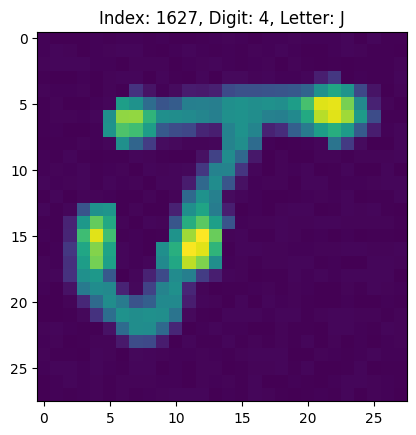

In [ ]:
# 이미지 확인
import random

idx = random.randint(0, 2048)
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [ ]:
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(train['digit'].values)

In [ ]:
# 성능을 높이는데, 이미지 데이터 증강이 중요해보였음

datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2)

#다양하게 진행한다고 해서 성능이 높아지는 것은 아님


In [ ]:
# cnn 모델 구축
# 이미지데이터 딥러닝 학습에서 가장 많이 사용되는 reLu 함수 사용

#채널 16추가

model = Sequential()

model.add(Conv2D(16, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(16, kernel_size = 3, activation='relu'))
model.add(Conv2D(16, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 64)         

In [ ]:
# learning rate 조절
lr = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [ ]:
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train, y_train, test_size = 0.1)

history = model.fit(
    datagen.flow(X_train2, y_train2, batch_size=32),
    epochs=epochs,
    steps_per_epoch=X_train2.shape[0]//32,
    validation_data=(X_val2, y_val2),
    callbacks=[lr],
    verbose=0
)


In [ ]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')

model_json = model.to_json()
with open(f"model.json", "w") as json_file :
    json_file.write(model_json)

In [ ]:
# 예측
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
pred = np.argmax(model.predict(X_test), axis=1)


640/640 [==============================] - 2s 3ms/step
(20480,)


In [ ]:
sub.digit = pred
sub.to_csv('CV3.csv', index=False)
